# Volume residual

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio, ab_initio_mcmc
from src.residual import get_volume_residual
import jax

import mrcfile

plt.rcParams["figure.figsize"]=6,6

In [3]:
data_dir = "/gpfs/gibbs/pi/lederman/dge5/CrossValidationCryodrgnSet/"
#star_file = "Projections/crossvalidation1_sub/crossvalidation1_sub.star"
#star_file = "Projections/crossvalidation1/crossvalidation1.star"
star_file = "Projections/crossvalidation1_zeros/crossvalidation1_zeros.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]

/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  26380
load_data: data loaded, time:  38.697288274765015


In [4]:
print(jnp.max(imgs0))
print(jnp.mean(imgs0))

6.80121
0.0031396088


In [5]:
print(imgs0.shape)
print(pixel_size0.shape)
print(angles0.shape)
print(shifts0.shape)
print(ctf_params0.shape)
nx0 = imgs0.shape[-1]
#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f0[101]))); plt.colorbar()



(26380, 320, 320)
(26380,)
(26380, 3)
(26380, 2)
(26380, 9)


In [6]:
N = imgs0.shape[0]

if N < imgs0.shape[0]:
    idxrand = np.random.permutation(imgs0.shape)[:N]
else:
    idxrand = jnp.arange(N)
    
imgs0 = imgs0[idxrand]
pixel_size = pixel_size0[idxrand]
angles = angles0[idxrand]
shifts = shifts0[idxrand]
ctf_params = ctf_params0[idxrand]

#file2 = open(out_dir + '/idxrand','wb')
#pickle.dump(idxrand, file2)
#file2.close()

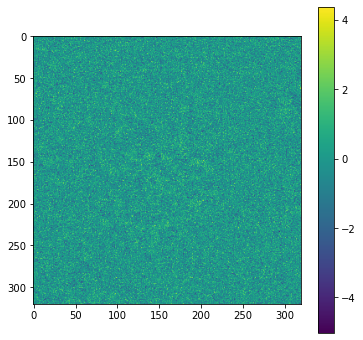

In [7]:
idx =123
plt.imshow(imgs0[idx]);plt.colorbar()

In [8]:
t0 = time.time()
imgs_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs0])
print(time.time()-t0)

74.39393758773804


In [9]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

[2.38549618e-03 3.20000000e+02]


### Crop images

In [10]:
nx = 128 #64
x_grid_nx0 = x_grid
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid_nx0, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)



[2.38549618e-03 1.28000000e+02]


In [11]:
imgs_f = imgs_f.reshape(N,-1)
print(imgs_f.shape)

(26380, 16384)


### More processing

Text(0.5, 1.0, 'Estimated noise')

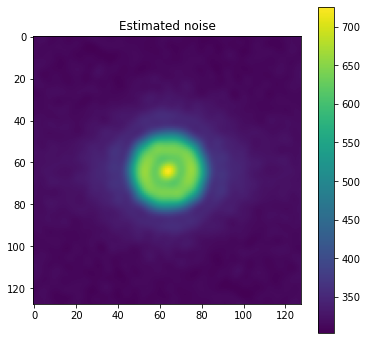

In [12]:
N_noise = 48
sigma_noise_estimated = estimate_noise_imgs(imgs0[:5000], nx_empty = N_noise, nx_final = nx).reshape([nx,nx])
plt.imshow(jnp.fft.fftshift(sigma_noise_estimated)); plt.colorbar()
plt.title('Estimated noise')

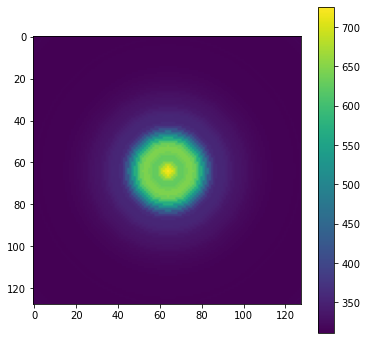

In [13]:
sigma_noise_avg = average_radially(sigma_noise_estimated, x_grid)
plt.imshow(jnp.fft.fftshift(sigma_noise_avg)); plt.colorbar()

In [24]:
sigma_noise = sigma_noise_avg.reshape(-1)

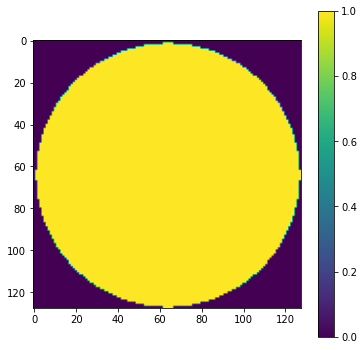

In [25]:
radius = 0.074 * 2.032
mask = create_3d_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Get residual

In [16]:
x_grid

array([2.38549618e-03, 1.28000000e+02])

In [17]:
jnp.complex128

jax._src.numpy.lax_numpy.complex128

In [18]:
mask2d = mask[0]

In [19]:
aa = jnp.array([[0,0],[0.1,0.1],[2,3], [0.14, 0.0001], [4, 20]])

In [20]:
aa.shape

(5, 2)

In [30]:
myidx = jnp.apply_along_axis(lambda x : x[0]**2 + x[1]**2 <= radius**2, axis=1, arr=aa)

In [31]:
myidx

DeviceArray([ True,  True, False,  True, False], dtype=bool)

In [32]:
aa[myidx]

DeviceArray([[0.0e+00, 0.0e+00],
             [1.0e-01, 1.0e-01],
             [1.4e-01, 1.0e-04]], dtype=float64)

In [33]:
x_grid

array([2.38549618e-03, 1.28000000e+02])

In [34]:
imgs_f.shape

(26380, 16384)

In [35]:
sigma_noise.shape

(16384,)

In [40]:
imgs_f[:10].shape

(10, 16384)

In [149]:
sigma_noise.shape

(16384,)

In [184]:
N_batches = 600 # for full dataset and 64

vol, vol_sigma, vol_counts = get_volume_residual(imgs_f[:50], angles[:50], sigma_noise, x_grid, radius, N_batches)

Rotate each image and get list of coords. 50 images in 10 batches...done in 0.4273374080657959 seconds.
Average residuals in each voxel. 624250 residuals in 600 batches.
Batch 0, 1.265833854675293 seconds.
Batch 10, 5.182154417037964 seconds.
Batch 20, 9.11816668510437 seconds.
Batch 30, 13.040950536727905 seconds.
Batch 40, 16.957303285598755 seconds.
Batch 50, 20.876421689987183 seconds.
Batch 60, 24.79907488822937 seconds.
Batch 70, 28.716432809829712 seconds.
Batch 80, 32.63538146018982 seconds.
Batch 90, 36.55868434906006 seconds.
Batch 100, 40.473857164382935 seconds.
Batch 110, 44.39077425003052 seconds.
Batch 120, 48.31407451629639 seconds.
Batch 130, 52.23370814323425 seconds.
Batch 140, 56.1554913520813 seconds.
Batch 150, 60.08043360710144 seconds.
Batch 160, 64.00114464759827 seconds.
Batch 170, 67.92358803749084 seconds.
Batch 180, 71.85018467903137 seconds.
Batch 190, 75.77042484283447 seconds.
Batch 200, 79.69208526611328 seconds.
Batch 210, 83.61692380905151 seconds.
Ba

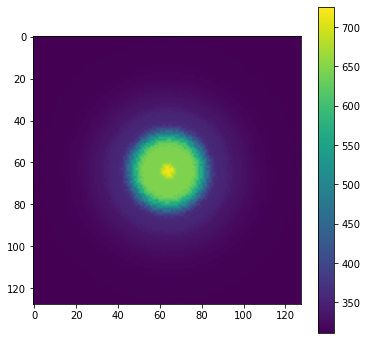

In [200]:
plt.imshow(jnp.max(jnp.fft.fftshift(vol_sigma), axis=0), vmin=jnp.min(sigma_noise_avg), vmax=jnp.max(sigma_noise_avg)); plt.colorbar()

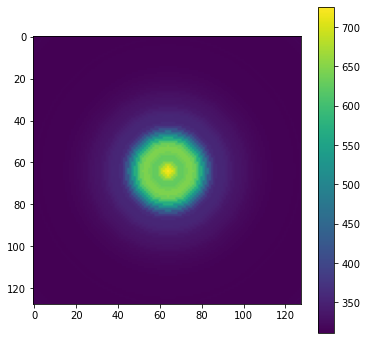

In [201]:
plt.imshow(jnp.fft.fftshift(sigma_noise_avg)); plt.colorbar()

In [202]:
print(jnp.max(vol_sigma))
print(jnp.max(sigma_noise_avg))

726.10693359375
726.10693359375


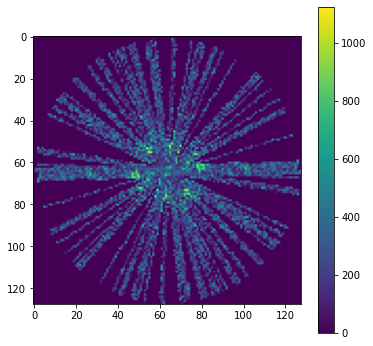

In [203]:
plt.imshow(jnp.abs(jnp.fft.fftshift(vol[0]))); plt.colorbar()

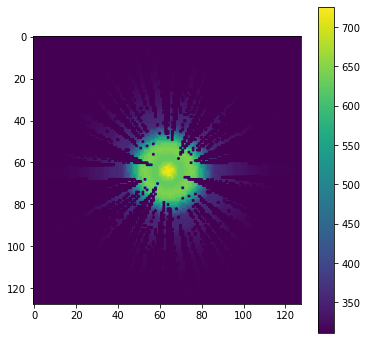

In [204]:
plt.imshow(jnp.fft.fftshift(vol_sigma[0]), vmin=jnp.min(sigma_noise_avg)); plt.colorbar()

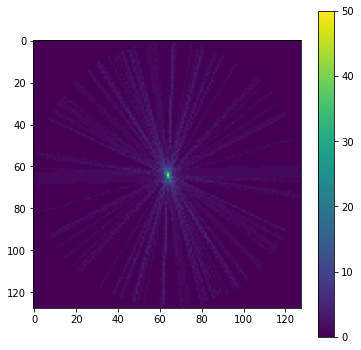

In [205]:
plt.imshow(jnp.fft.fftshift(vol_counts[0])); plt.colorbar()

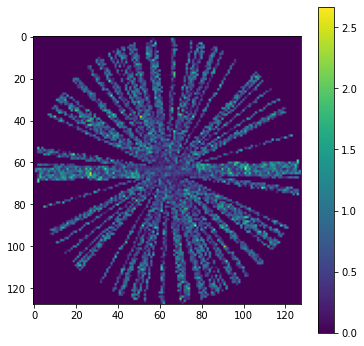

In [206]:
vs = vol/(vol_sigma+1e-16)

plt.imshow(jnp.abs(jnp.fft.fftshift(vs[0]))); plt.colorbar()

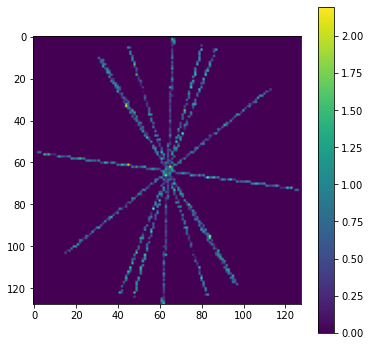

In [ ]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_resid3[0]))); plt.colorbar()

In [208]:
plt.imshow(jnp.fft.fftshift(v_resid[:,:,0]*mask[:,:,0])); plt.colorbar()

NameError: name 'v_resid' is not defined

In [ ]:
v_resid_print = jnp.fft.fftshift(v_resid*mask)
with mrcfile.new('../data/cryodrgn_crossvalidation/v_resid_cv2_128.mrc', overwrite=True) as mrc:
    mrc.set_data(v_resid_print.astype(np.float32))

In [45]:
r0 = mrcfile.open('../data/cryodrgn_crossvalidation/v_resid_cv1_zero_64.mrc').data
rv = mrcfile.open('../data/cryodrgn_crossvalidation/v_resid_cv1_64_proj.mrc').data

In [36]:
jnp.sum(jnp.abs(r0-rv))

DeviceArray(5041074., dtype=float32)

In [25]:
r0 = mrcfile.open('../data/cryodrgn_crossvalidation/v_resid_cv1_zero_128.mrc').data
rv = mrcfile.open('../data/cryodrgn_crossvalidation/v_resid_cv1_128.mrc').data


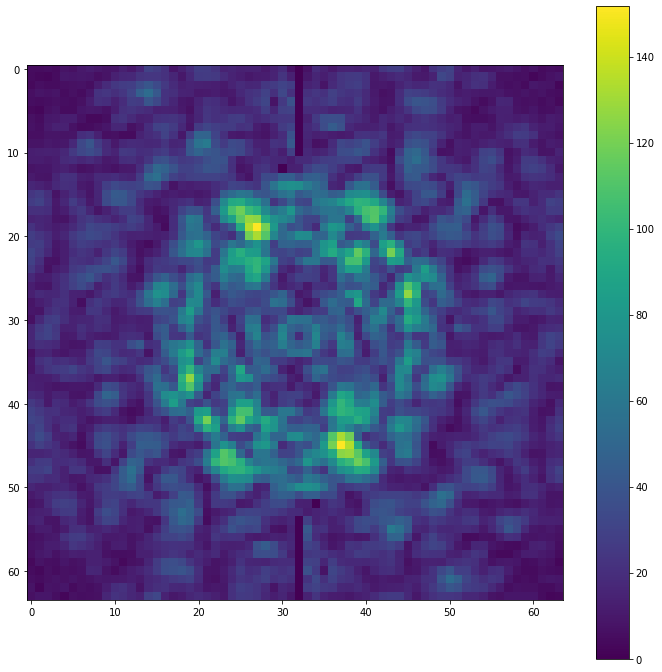

In [49]:
plt.imshow(rv[:,:,32]); plt.colorbar()

In [32]:
jnp.sum(jnp.abs(r0-rv))

DeviceArray(0., dtype=float32)

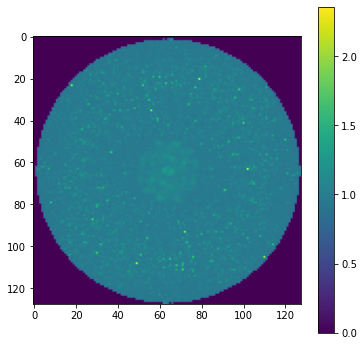

In [30]:
mip_z(rv); plt.colorbar()

### New volumes

In [24]:
with open('../data/cryodrgn_crossvalidation/cv1_proj_32', 'rb') as file:
    # Call load method to deserialze
    proj = pickle.load(file)


In [29]:
proj[0,0]

array([ 19.01725458,  35.90536084,  45.91661398,  16.16830083,
        -3.36572933, -13.29117774,  -6.34324598,   1.37270153,
         7.37385469,   6.56053346,   4.03242771,   2.40700772,
         3.34642496,   2.60984252,   1.15996835,   1.03297985,
        -0.04606021,   0.55394648,   0.81718212,   2.72114988,
         3.42498891,   2.42703735,   4.12682434,   6.56053346,
         7.37385469,   1.37270153,  -6.34324598, -13.29117774,
        -3.36572933,  16.16830083,  45.91661398,  35.90536084])